In [1]:
import numpy as np
import pandas as pd

from PIL import Image
import tensorflow as tf

from sklearn.model_selection import train_test_split
from skimage.transform import resize
from sklearn.metrics import accuracy_score

from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPool2D, Dense, Flatten, Dropout

import matplotlib.pyplot as plt
import seaborn as sns
import os
import cv2

import warnings
warnings.filterwarnings('ignore')

# Load Training Images Data

In [2]:
trainDF = pd.read_csv('../data/gtsrb-german-traffic-sign/Train.csv')

X_train = trainDF['Path']
y_train = trainDF.ClassId

trainDF

,Width,Height,Roi.X1,Roi.Y1,Roi.X2,Roi.Y2,ClassId,Path
0,27,26,5,5,22,20,20,Train/20/00020_00000_00000.png
1,28,27,5,6,23,22,20,Train/20/00020_00000_00001.png
2,29,26,6,5,24,21,20,Train/20/00020_00000_00002.png
3,28,27,5,6,23,22,20,Train/20/00020_00000_00003.png
4,28,26,5,5,23,21,20,Train/20/00020_00000_00004.png
...,...,...,...,...,...,...,...,...
39204,52,56,5,6,47,51,42,Train/42/00042_00007_00025.png
39205,56,58,5,5,51,53,42,Train/42/00042_00007_00026.png
39206,58,62,5,6,53,57,42,Train/42/00042_00007_00027.png
39207,63,69,5,7,58,63,42,Train/42/00042_00007_00028.png


## Get Training images & Resize to 30x30

In [3]:
data_dir = "../data/gtsrb-german-traffic-sign"
train_imgpath = list((data_dir + '/' + str(trainDF.Path[i])) for i in range(len(trainDF.Path)))

train_data = []
train_labels = []

path = "../data/gtsrb-german-traffic-sign/"

for i in range(len(trainDF.Path)):
    image = cv2.imread(train_imgpath[i])
    image_from_array = Image.fromarray(image, 'RGB')
    size_image = image_from_array.resize((30,30))
    train_data.append(np.array(size_image))
    train_labels.append(trainDF.ClassId[i])

img_data = np.array(train_data)
img_labels = np.array(train_labels)

print(img_data.shape, img_labels.shape)

(39209, 30, 30, 3) (39209,)


## Train Test Split

In [4]:
X_train, X_test, y_train, y_test = train_test_split(img_data, img_labels, test_size= 0.20, random_state = 96)

print((X_train.shape, y_train.shape), (X_test.shape, y_test.shape))

((31367, 30, 30, 3), (31367,)) ((7842, 30, 30, 3), (7842,))


## One-Hot Encode

In [5]:
y_train = to_categorical(y_train, 43)
y_test = to_categorical(y_test, 43)

# Build Network Structure
### Activation - relu
### Dropout - .25

In [6]:
model = Sequential()

model.add(Conv2D(filters = 32, kernel_size = (5,5), activation ='relu', data_shape = (30,30,3)))
model.add(MaxPool2D(pool_size = (2,2)))
model.add(Dropout(rate = 0.25))

model.add(Conv2D(filters = 64, kernel_size = (3,3), activation ='relu'))
model.add(MaxPool2D(pool_size = (2,2)))
model.add(Dropout(rate = 0.25))

model.add(Flatten())
model.add(Dense(128, activation = 'relu'))
model.add(Dropout(rate = 0.5))
model.add(Dense(43, activation= 'softmax'))

model.compile(loss = 'categorical_crossentropy', optimizer ='adam', metrics =['accuracy'])

## Review the Network Structure

In [7]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 26, 26, 32)        2432      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 13, 13, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 11, 11, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 5, 5, 64)          0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 5, 5, 64)          0         
_________________________________________________________________
flatten (Flatten)            (None, 1600)              0

## Fit Model on Training

In [8]:
history = model.fit(X_train, y_train, 
                   batch_size = 64,
                   epochs = 20,
                   validation_data = (X_test, y_test))

Epoch 1/20
491/491 [==============================] - 9s 17ms/step - loss: 6.9401 - accuracy: 0.0588 - val_loss: 2.9314 - val_accuracy: 0.2266
Epoch 2/20
491/491 [==============================] - 8s 16ms/step - loss: 2.9512 - accuracy: 0.1950 - val_loss: 2.1669 - val_accuracy: 0.3874
Epoch 3/20
491/491 [==============================] - 8s 16ms/step - loss: 2.4758 - accuracy: 0.2620 - val_loss: 1.6497 - val_accuracy: 0.4749
Epoch 4/20
491/491 [==============================] - 8s 17ms/step - loss: 2.1998 - accuracy: 0.3143 - val_loss: 1.5598 - val_accuracy: 0.5167
Epoch 5/20
491/491 [==============================] - 8s 16ms/step - loss: 2.0352 - accuracy: 0.3610 - val_loss: 1.2974 - val_accuracy: 0.5622
Epoch 6/20
491/491 [==============================] - 8s 17ms/step - loss: 1.8165 - accuracy: 0.4172 - val_loss: 1.1114 - val_accuracy: 0.6164
Epoch 7/20
491/491 [==============================] - 8s 17ms/step - loss: 1.6219 - accuracy: 0.4756 - val_loss: 0.9082 - val_accuracy: 0.7015

# Evaluate by looking at plots

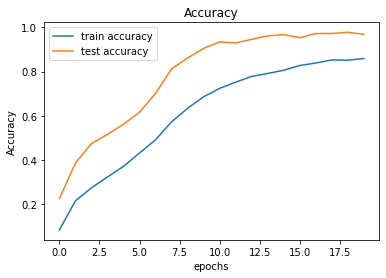

In [9]:
plt.figure(0)
plt.plot(history.history['accuracy'], label= 'train accuracy')
plt.plot(history.history['val_accuracy'], label= 'test accuracy')
plt.title('Accuracy')
plt.xlabel('epochs')
plt.ylabel('Accuracy')
plt.legend()

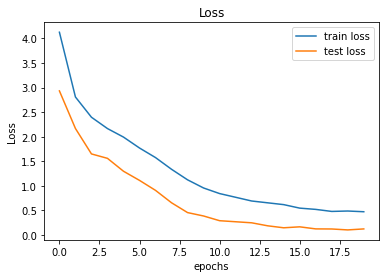

In [10]:
plt.figure(0)
plt.plot(history.history['loss'], label= 'train loss')
plt.plot(history.history['val_loss'], label= 'test loss')
plt.title('Loss')
plt.xlabel('epochs')
plt.ylabel('Loss')
plt.legend()

# Make Prediction with Test Dataset

In [11]:
y_test = pd.read_csv('../data/gtsrb-german-traffic-sign/Test.csv')

img_test = y_test['Path'].values
labels_test = y_test['ClassId'].values


test_dir = '../data/gtsrb-german-traffic-sign'
data = []


for img in img_test:
    img_path = os.path.join(test_dir, img)
    image = cv2.imread(img_path, -1)
    image = cv2.resize(image, (30,30), interpolation = cv2.INTER_NEAREST)
    data.append(np.array(image))
    
X_testing = np.array(data)

In [13]:
pred = model.predict_classes(X_testing)

print("Test accuracy: ", accuracy_score(labels_test, pred) * 100 )

Test accuracy:  89.02612826603325
